In [1]:
from tsai.basics import *
import sktime
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
my_setup(sktime, sklearn)

os             : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.17
python         : 3.8.12
tsai           : 0.3.1
fastai         : 2.6.3
fastcore       : 1.4.4
sktime         : 0.10.1
sklearn        : 1.0.2
torch          : 1.11.0
device         : cpu
cpu cores      : 16
RAM            : 24.88 GB
GPU memory     : N/A


In [2]:
from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize
import pandas as pd

In [3]:
from tsai.all import *

In [4]:
df = pd.read_csv('dataset_with_rain_and_atm(1).csv')

In [5]:
df

,Timestamp,Value-1002-zeya-malayasazanka,Value-1003-zeya-svobodny,Value-2366-zeya-blagoveshensk,Value-316-zeya-mazanovo,Value-317-zeya-belogorye,snow_high,snow_level,snow_Q1,1.2,1.3,0.1,4,9,8,20,1.4,41,0.3,21.00
0,2008-01-01,435,163,148,218,341,4.0,10.0,0.0,1.0,1.0,12.0,8.0,21.0,8.0,20.0,1.0,11.0,0.0,11.2
1,2008-01-02,441,162,151,222,350,4.0,10.0,0.0,1.0,2.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
2,2008-01-03,447,161,157,226,361,4.0,10.0,0.0,1.0,3.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
3,2008-01-04,447,154,163,230,367,4.0,10.0,0.0,1.0,4.0,0.0,4.0,9.0,8.0,20.0,1.0,11.0,0.0,22.3
4,2008-01-05,443,144,168,222,364,4.0,10.0,0.0,1.0,5.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,14.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,2020-12-27,434,167,134,235,343,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4
4745,2020-12-28,435,169,134,235,343,5.0,10.0,0.0,12.0,28.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.0
4746,2020-12-29,438,171,132,232,342,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4
4747,2020-12-30,437,137,132,237,366,5.0,10.0,0.0,12.0,27.0,15.0,1.0,0.0,8.0,20.0,1.0,11.0,0.0,12.4


In [6]:
# X - Признаки(данные без благовещенска)
# y - Предикт (Только Благовещенск), т.к. предсказываем для благовещенска
def create_multiple_dataset(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    
    return new_X, new_y

x_zavtra = 0

def help_function(df, num_days=365, days_forward=1):
    global x_zavtra
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+2])
    new_X = np.concatenate(array_for_concat, axis=-1)
    x_zavtra = new_X[-1:]
    new_X = new_X[:-1]
    #y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    '''array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)'''
    
    return new_X


def create_data_set_without_blagoveshensk(df, num_days=365, days_forward=1):
    X, y = create_multiple_dataset(df, num_days,  days_forward)
    X = help_function(df, num_days, days_forward)
    return X, y

#df_without_blagoveshensk = df[['zeya-malayasazanka', 'zeya-svobodny', 'zeya-mazanovo', 'zeya-belogorye']]
#df_only_blagoveshensk = df[['zeya-blagoveshensk']]
X, y = create_data_set_without_blagoveshensk(df, days_forward=10)
y.shape

(4375, 10)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=10, shuffle=False)
X_train.shape

(4365, 19, 365)

In [26]:
# Univariate regression with sklearn-type API

X_train, y_train = shuffle(X_train, y_train)

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
#print(model)
timer.start(False)
model.fit(X_train, y_train)
t = timer.stop()
y_pred = model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
mae = mean_absolute_error(y_valid, y_pred)
print(f'valid rmse        : {rmse:.5f}')
print(f'valid mae        : {mae:.5f}')

valid rmse        : 34.28877
valid mae        : 30.52947


In [29]:

model.save('MiniRocket')

In [9]:
model = load_minirocket('MiniRocket')

In [27]:
y_predict = model.predict(X)
y_valid_predict = y_predict[-10:]

In [29]:
import matplotlib.pyplot as plt

In [30]:
y_valid = y[-10:]

In [31]:

rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
mae = mean_absolute_error(y_valid, y_valid_predict)

print(f'valid rmse        : {rmse:.5f}')
print(f'valid mae        : {mae:.5f}')

valid rmse        : 34.28877
valid mae        : 30.52947


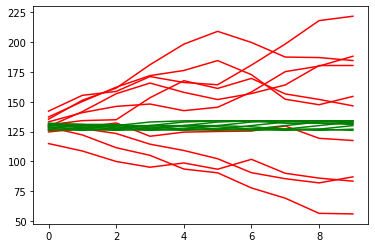

In [32]:
x = list(range(0, len(y_valid_predict)))
np.reshape(x, (len(x), 1))
plt.plot(x, y_valid_predict, 'r')
plt.plot(x, y_valid, 'g')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

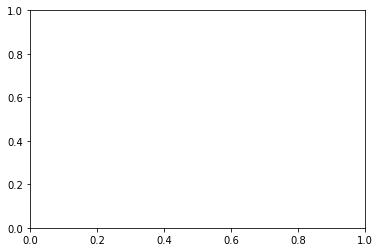

In [33]:
x = list(range(0, len(y_valid_predict)))
np.reshape(x, (len(x), 1))
error = (y_valid.reshape(-1) - y_valid_predict.reshape(-1)) / y_valid.reshape(-1)
plt.plot(x, error, 'g')
plt.show()

In [ ]:
x = list(range(0, len(y)))
np.reshape(x, (len(x), 1))
plt.plot(x, y_predict, 'r')
plt.plot(x, y, 'g')
plt.show()

In [ ]:
y[y>450]
x = list(range(0, len(y[y>450])))
np.reshape(x, (len(x), 1))
plt.plot(x, y_predict[y>450], 'r')
plt.plot(x, y[y>450], 'g')
plt.show()

In [ ]:
variance = mean_squared_error(y, y_predict, squared=False)

In [ ]:
variance

In [ ]:
c = 1.96

In [ ]:
x_draw = list(range(22))
y_draw = y_predict[-30:-8]
plt.plot(x_draw, y_draw, color='r')
plt.fill_between(x_draw[-2:], y_draw[-2:].reshape(-1) - c * variance, y_draw[-2:].reshape(-1) + c * variance, color='r', alpha=.1)

In [ ]:
plt.plot(list(range(10)), y_valid_predict[0])
plt.plot(list(range(10)), y_valid[0])

In [34]:
variances = np.array([mean_squared_error(y[:, i:i+1], y_predict[:, i:i+1], squared=False) for i in range(10)])

In [35]:
def draw_confidence_intervals(y_true, y_predict, variances=0, c=1.96):
    x_draw = list(range(len(y_true)))
    plt.plot(x_draw, y_predict, color='r')
    plt.plot(x_draw, y_true, color='g')
    plt.fill_between(x_draw, y_predict.reshape(-1) - variances * c, y_predict.reshape(-1) + variances * c, color='r', alpha=0.1)

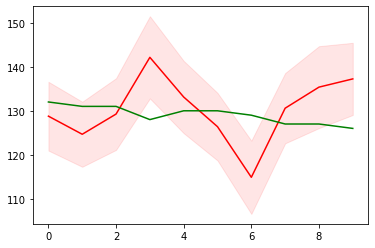

In [36]:
draw_confidence_intervals(y_valid[0], y_valid_predict[0], variances)

In [43]:
def draw_crit_lines(crit_levels=[400]):
    x = df.Timestamp.to_numpy(dtype=np.datetime64)[-y.shape[0]:]
    y_crit = np.zeros(y.shape[0])
    y_predict_crit = np.zeros(y.shape[0])
    for i in range(len(crit_levels)):
        y_crit[y[:, 0]>=crit_levels[i]]=i+1
        y_predict_crit[y_predict[:, 0]>=crit_levels[i]]=i+1
    
    plt.plot(x, y_crit, color='g')
    plt.plot(x, y_predict_crit, color='r')

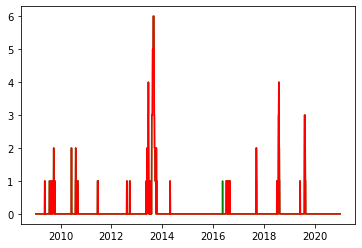

In [46]:
draw_crit_lines([300, 400, 500, 600, 700, 800])